# Import

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
torch.cuda.empty_cache()

import pickle
import os
from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce

class Generator(nn.Module):
    def __init__(self, seq_len=64, patch_size=24, channels=1, num_classes=9, latent_dim=100, embed_dim=10, depth=3,
                 num_heads=5, forward_drop_rate=0.5, attn_drop_rate=0.5):
        super(Generator, self).__init__()
        self.channels = channels
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.depth = depth
        self.attn_drop_rate = attn_drop_rate
        self.forward_drop_rate = forward_drop_rate

        self.l1 = nn.Linear(self.latent_dim, self.seq_len * self.embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.seq_len, self.embed_dim))
        self.blocks = Gen_TransformerEncoder(
            depth=self.depth,
            emb_size=self.embed_dim,
            drop_p=self.attn_drop_rate,
            forward_drop_p=self.forward_drop_rate
        )

        self.deconv = nn.Sequential(
            nn.Conv2d(self.embed_dim, self.channels, 1, 1, 0)
        )

    def forward(self, z):
        x = self.l1(z).view(-1, self.seq_len, self.embed_dim)
        x = x + self.pos_embed
        H, W = 1, self.seq_len
        x = self.blocks(x)
        x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        output = self.deconv(x.permute(0, 3, 1, 2))
        output = output.view(-1, self.channels, H, W)
        return output


class Gen_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=5,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class Gen_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=8, **kwargs):
        super().__init__(*[Gen_TransformerEncoderBlock(**kwargs) for _ in range(depth)])


class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )


class Dis_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size=100,
                 num_heads=5,
                 drop_p=0.,
                 forward_expansion=4,
                 forward_drop_p=0.):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class Dis_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=8, **kwargs):
        super().__init__(*[Dis_TransformerEncoderBlock(**kwargs) for _ in range(depth)])


class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=100, n_classes=1):
        super().__init__()
        self.clshead = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

    def forward(self, x):
        out = self.clshead(x)
        return out


class PatchEmbedding_Linear(nn.Module):
    def __init__(self, in_channels=1, patch_size=16, emb_size=100, seq_length=1024):
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=1, s2=patch_size),
            nn.Linear(patch_size * in_channels, emb_size)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((seq_length // patch_size) + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x


class Discriminator(nn.Sequential):
    def __init__(self,
                 in_channels=1,
                 patch_size=24,
                 emb_size=50,
                 seq_length=24,
                 depth=3,
                 n_classes=1,
                 **kwargs):
        super().__init__(
            PatchEmbedding_Linear(in_channels, patch_size, emb_size, seq_length),
            Dis_TransformerEncoder(depth, emb_size=emb_size, drop_p=0.5, forward_drop_p=0.5, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

# Paramètres
def get_generator(save_dir):

    # Chargement des infos
    with open(os.path.join(save_dir, 'info_normalisation.pkl'), 'rb') as f:
        info_normalisation = pickle.load(f)
    
    # Chargement des infos
    with open(os.path.join(save_dir, 'info_model.pkl'), 'rb') as f:
        info_modele = pickle.load(f)

    # Paramètres d'entraînement
    batch_size , seq_len , patch_size , latent_dim , nb_channels = info_modele

    generator = Generator(seq_len=seq_len, 
                        patch_size=patch_size,
                        channels=nb_channels,
                        latent_dim=latent_dim,
                        ).to('cpu')

    # Chargez les poids sauvegardés
    generator.load_state_dict(torch.load(os.path.join(save_dir, 'generator.pth'), weights_only=True))

    print("Les modèles ont été récupérés avec succès.")

    return generator

# Exemple d'utilisation
# 
# Modèle à récupérer
# save_dir = "model_saved/1900_1_sinus_0.01_moyen_12_11_2024"

In [38]:
save_dir = "model_saved/1900_1_sinus_0.01_moyen_12_11_2024"
generator = get_generator(save_dir)

Les modèles ont été récupérés avec succès.


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
torch.cuda.empty_cache()
import math
import numpy as np

import pickle
import scipy
import os
from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

- Récupérer le modèle et faire une fonction simple qui génère des signaux avec les modèles

# Architecture des modèles

In [40]:
# Définition des classes du modèle (comme dans votre code)
class Generator(nn.Module):
    def __init__(self, seq_len=64, patch_size=24, channels=1, num_classes=9, latent_dim=100, embed_dim=10, depth=3,
                 num_heads=5, forward_drop_rate=0.5, attn_drop_rate=0.5):
        super(Generator, self).__init__()
        self.channels = channels
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.depth = depth
        self.attn_drop_rate = attn_drop_rate
        self.forward_drop_rate = forward_drop_rate

        self.l1 = nn.Linear(self.latent_dim, self.seq_len * self.embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.seq_len, self.embed_dim))
        self.blocks = Gen_TransformerEncoder(
            depth=self.depth,
            emb_size=self.embed_dim,
            drop_p=self.attn_drop_rate,
            forward_drop_p=self.forward_drop_rate
        )

        self.deconv = nn.Sequential(
            nn.Conv2d(self.embed_dim, self.channels, 1, 1, 0)
        )

    def forward(self, z):
        x = self.l1(z).view(-1, self.seq_len, self.embed_dim)
        x = x + self.pos_embed
        H, W = 1, self.seq_len
        x = self.blocks(x)
        x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        output = self.deconv(x.permute(0, 3, 1, 2))
        output = output.view(-1, self.channels, H, W)
        return output


class Gen_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=5,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class Gen_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=8, **kwargs):
        super().__init__(*[Gen_TransformerEncoderBlock(**kwargs) for _ in range(depth)])


class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )


class Dis_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size=100,
                 num_heads=5,
                 drop_p=0.,
                 forward_expansion=4,
                 forward_drop_p=0.):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class Dis_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=8, **kwargs):
        super().__init__(*[Dis_TransformerEncoderBlock(**kwargs) for _ in range(depth)])


class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=100, n_classes=1):
        super().__init__()
        self.clshead = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

    def forward(self, x):
        out = self.clshead(x)
        return out


class PatchEmbedding_Linear(nn.Module):
    def __init__(self, in_channels=1, patch_size=16, emb_size=100, seq_length=1024):
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=1, s2=patch_size),
            nn.Linear(patch_size * in_channels, emb_size)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((seq_length // patch_size) + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x


class Discriminator(nn.Sequential):
    def __init__(self,
                 in_channels=1,
                 patch_size=24,
                 emb_size=50,
                 seq_length=24,
                 depth=3,
                 n_classes=1,
                 **kwargs):
        super().__init__(
            PatchEmbedding_Linear(in_channels, patch_size, emb_size, seq_length),
            Dis_TransformerEncoder(depth, emb_size=emb_size, drop_p=0.5, forward_drop_p=0.5, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

# Config

In [41]:
# Configuration du dispositif (CPU ou GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


# Modèle à récupérer

In [86]:
save_dir = "model/1900_f1_0.001_moyen_12_11_2024"

# Paramètres

In [87]:
def get_generator(save_dir):

    # Chargement des infos
    with open(os.path.join(save_dir, 'info_normalisation.pkl'), 'rb') as f:
        info_normalisation = pickle.load(f)
    
    # Chargement des infos
    with open(os.path.join(save_dir, 'info_model.pkl'), 'rb') as f:
        info_modele = pickle.load(f)

    # Paramètres d'entraînement
    batch_size , seq_len , patch_size , latent_dim , nb_channels = info_modele

    generator = Generator(seq_len=seq_len, 
                        patch_size=patch_size,
                        channels=nb_channels,
                        latent_dim=latent_dim,
                        ).to(device)

    # Chargez les poids sauvegardés
    generator.load_state_dict(torch.load(os.path.join(save_dir, 'generator.pth'), weights_only=True))

    print("Les modèles ont été récupérés avec succès.")

    return generator

In [88]:
# Chargement des infos
with open(os.path.join(save_dir, 'info_normalisation.pkl'), 'rb') as f:
    info_normalisation = pickle.load(f)

print(info_normalisation) 

([-15.0], [384.0])


In [89]:
# Chargement des infos
with open(os.path.join(save_dir, 'info_model.pkl'), 'rb') as f:
    info_modele = pickle.load(f)

print(info_modele) 

[16, 1900, 100, 1000, 1]


In [90]:
# Paramètres d'entraînement
batch_size , seq_len , patch_size , latent_dim , nb_channels = info_modele

# Récupération des modèles

In [91]:
generator = Generator(seq_len=seq_len, 
                      patch_size=patch_size,
                      channels=nb_channels,
                      latent_dim=latent_dim,
                      ).to(device)
discriminator = Discriminator(in_channels=nb_channels,
                              patch_size=patch_size,
                              emb_size=50,
                              seq_length=seq_len).to(device)

# Chargez les poids sauvegardés
generator.load_state_dict(torch.load(os.path.join(save_dir, 'generator.pth'), weights_only=True))
discriminator.load_state_dict(torch.load(os.path.join(save_dir, 'discriminator.pth'), weights_only=True))

print("Les modèles ont été récupérés avec succès.")

Les modèles ont été récupérés avec succès.


# Fonction pour générer les signaux

In [92]:
def denormalisation_signaux(signaux, info_normalisation):

    min = info_normalisation[0]
    max = info_normalisation[1]

    for i in range(signaux.shape[1]):
        signaux[0, i, 0] = signaux[0, i, 0] * (max[i] - min[i]) + min[i]

    return signaux

In [93]:
def generate_signaux_from_model(generator):
    z = torch.randn(1, latent_dim).to(device)
    generated_signal = generator(z).detach().cpu().numpy()


    # generated_signal = denormalisation_signaux(generated_signal, info_normalisation)

    return generated_signal

In [94]:
generate_signaux_from_model(generator)

array([[[[0.06808124, 0.06178443, 0.03921306, ..., 0.06365975,
          0.05554027, 0.05999378]]]], dtype=float32)

# Affichage

In [95]:
def affichage_signal(signal):
    # Diviser le plot en 5 parties
    fig, axs = plt.subplots(nb_channels, 1, figsize=(9, 1), sharex=True)

    if nb_channels == 1:
        axs = [axs]  # Convertir en liste pour accéder par index

    # Affichage du signal réel
    for i in range(nb_channels):
        axs[i].plot(signal[0][i].reshape(seq_len), label=f'Signal généré {i+1}')
        axs[i].grid()
    
    # plt.suptitle("Signal Généré")
    plt.show()

(1, 1, 1, 1900)
[[0.06351258 0.07632078 0.08061719 ... 0.05626369 0.0723618  0.081615  ]]


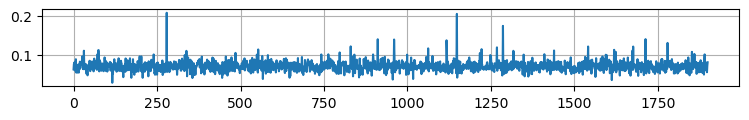

In [112]:
signal_generateur = generate_signaux_from_model(generator)

print(signal_generateur.shape)
print(signal_generateur[0, 0])

affichage_signal(signal_generateur)